<h1>Trabajo final Aprendizaje de Maquinas 1</h1>

Alumnos:

*   Avalos Ribas Gonzalo
*   Rassi Francisco
*   Silva Victor

Dataset: "Datos de distintas canciones en Spotify".
Este dataset se obtuvo de los datasets propuestos en la cátedra de Análisis de Datos, el mismo se encuntra en el siguiente enlace:

https://drive.google.com/file/d/1c1l3OMUFjQWcydV0srKe95LLEfkBMKia/view



La evaluación de estos datos se debe a que Spotify es una plataforma de streaming de música muy popular y que contiene una gran cantidad de datos sobre las preferencias de los usuarios, las características de las canciones y otros aspectos relacionados con la música. Evaluar estos datos puede proporcionar información valiosa sobre los hábitos de escucha de los usuarios, las tendencias musicales, la popularidad de ciertas canciones o artistas, entre otros aspectos.

Particularmente nuestro objetivo de investigación es poder estimar si un tema nuevo será del gusto de la persona que tiene esta playlist activa. Para ello se aplicarán diferentes algoritmos vistos a lo largo del cursado en este proyecto, luego se realizará una comparación entre estos algoritmos para conocer el que mejor desempeño obtuvo.

# Análisis de los datos y extracción de características principales

En esta primera parte se mostrará aspectos generales del dataset como sus features, la relación entre las features realizando la correlación entre estas, y poder determinar cuales son las features más importantes para poder aplicar los algorimos de machine learning. Esta es necesaria para familiarizarse con los datos y sobre todo porque un buen tratamiento de los datos permite mejorar el desempeño de los algoritmos.

In [120]:
import pandas as pd
import numpy as np
url = "https://raw.githubusercontent.com/Vic-bit/analisis_de_datos_CEIA/main/trabajo_final/data_playlist.csv"
data_playlist = pd.read_csv(url)

El dataset elegido se corresponde con canciones de spotify, para cada una se muestran ciertas caracteristicas. El objetivo del analisis es predecir si la salida es 1, es decir que deberia estar en la playlist de la persona. O 0 si no deberia estar en la playlist de la persona.

In [121]:
data_playlist.head()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,label
0,0.713,0.514,100125,0.521,0.816000,8,0.1120,-14.835,0,0.0444,119.879,4,0.143,1
1,0.192,0.714,207019,0.614,0.000000,4,0.2630,-6.935,1,0.0319,123.969,4,0.582,1
2,0.333,0.630,216200,0.455,0.000004,5,0.1270,-9.290,1,0.0292,139.931,4,0.199,1
3,0.601,0.810,136413,0.221,0.210000,5,0.1840,-11.005,1,0.0429,109.960,4,0.798,1
4,0.883,0.465,181440,0.459,0.000173,6,0.0692,-8.137,0,0.0351,90.807,4,0.288,1


A simple vista podemos separar las variables en aquellas que son cuantitativas o cualitativas.

In [122]:
VARIABLE_ENTRADA_CUALI = ['key','mode','time_signature']
VARIABLE_ENTRADA_CUANTI =  ['acousticness','danceability','duration','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']
SALIDA=['label']

Las siguientes secciones son un análisis sobre la correlación que existe entre las variables de entrada ya sean numericas o categóricas, y la salida. Para esto utilizamos diferentes medidas de correlación.

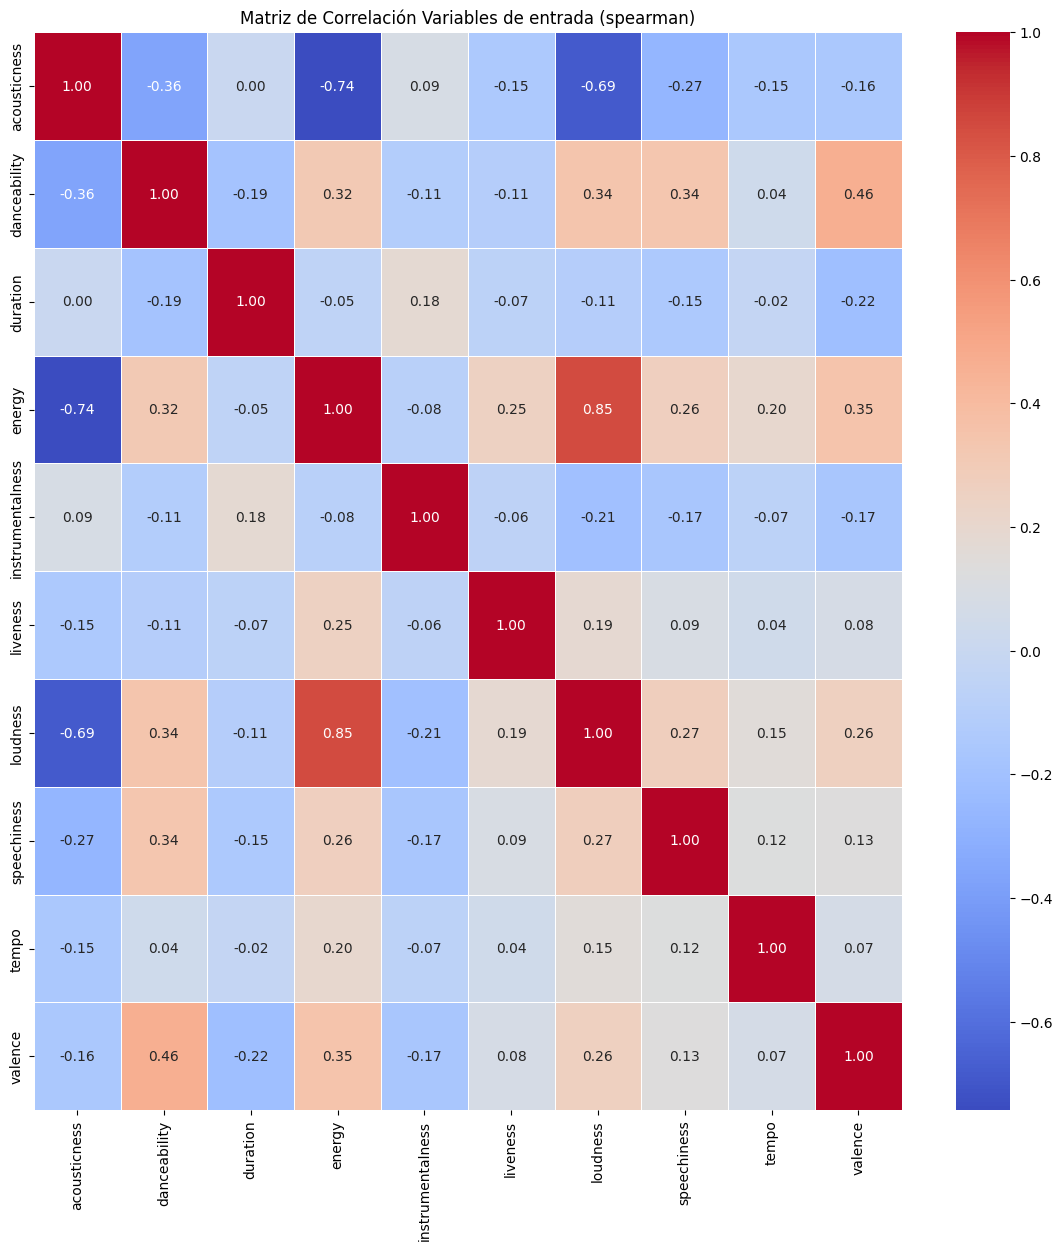

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = data_playlist[VARIABLE_ENTRADA_CUANTI].corr(method='spearman')
plt.figure(figsize=(14, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación Variables de entrada (spearman)')
plt.show()

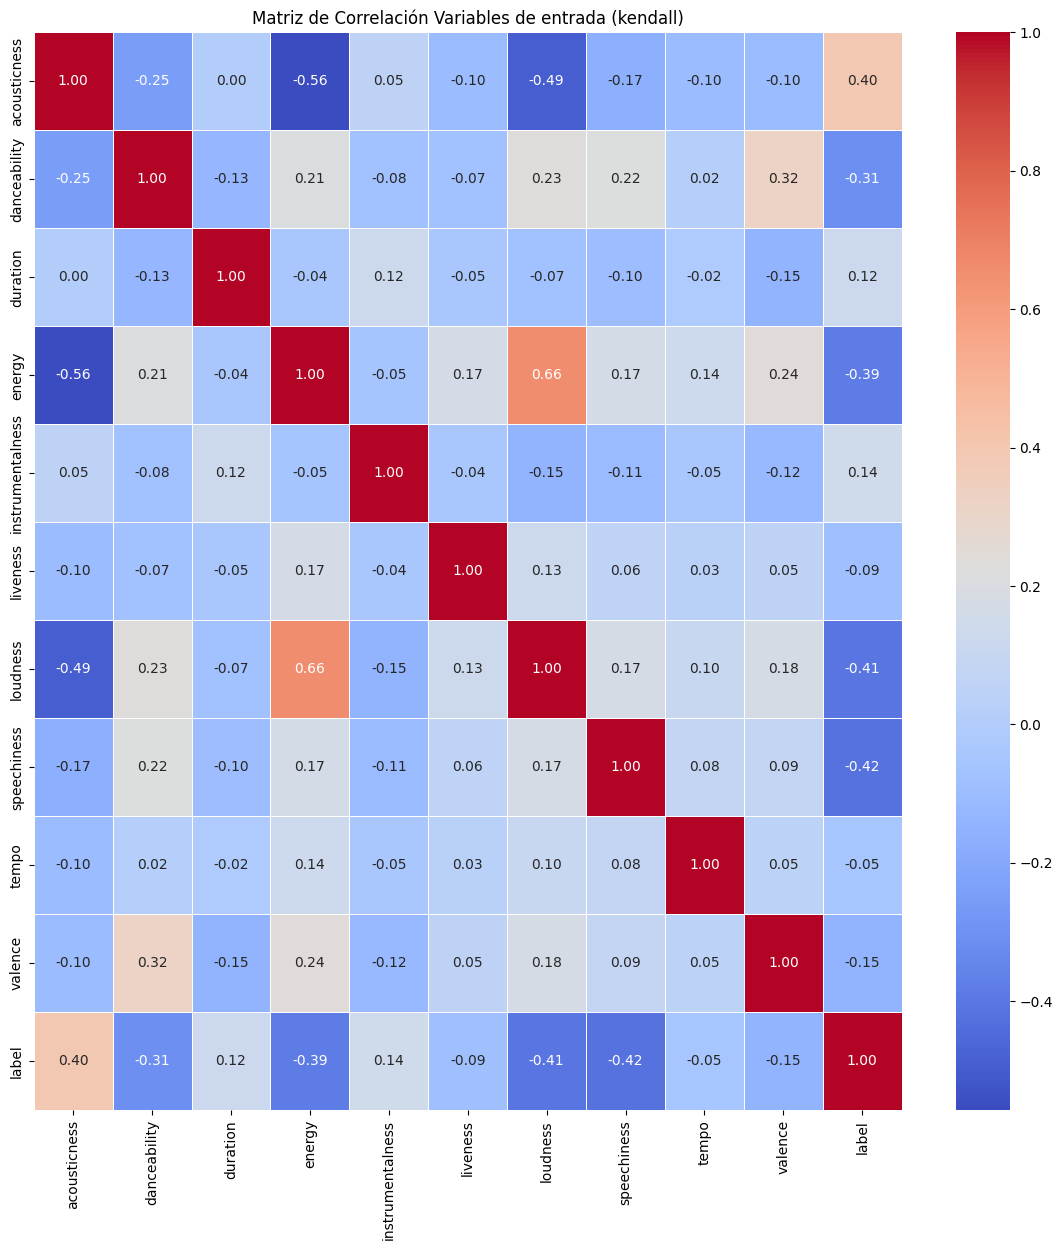

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = data_playlist[VARIABLE_ENTRADA_CUANTI + SALIDA].corr(method='kendall')
plt.figure(figsize=(14, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación Variables de entrada (kendall)')
plt.show()

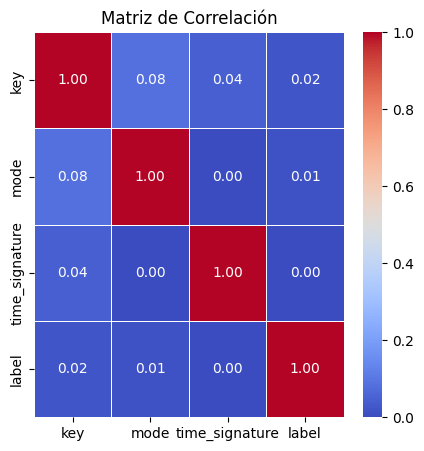

In [125]:
from sklearn.feature_selection import mutual_info_regression

def custom_mi_reg(a, b):
    a = a.reshape(-1, 1)
    return  mutual_info_regression(a, b)[0]


correlation_matrix = data_playlist[VARIABLE_ENTRADA_CUALI + SALIDA].corr(method=custom_mi_reg)
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

A partir de nuestro análisis determinamos que las variables independientes que tienen mayor correlacion con la salida son:

*   danceability
*   energy
*   speechiness



In [126]:
HIGH_LINEAR_CORRELATION_VARIABLES= ['danceability','energy','speechiness']
data_valuable = data_playlist[HIGH_LINEAR_CORRELATION_VARIABLES + SALIDA]

In [127]:
data_valuable.head()

,danceability,energy,speechiness,label
0,0.514,0.521,0.0444,1
1,0.714,0.614,0.0319,1
2,0.630,0.455,0.0292,1
3,0.810,0.221,0.0429,1
4,0.465,0.459,0.0351,1


In [128]:
data_valuable.describe()

,danceability,energy,speechiness,label
count,750.000000,750.000000,750.000000,750.000000
mean,0.596439,0.594188,0.098966,0.602667
std,0.172036,0.253301,0.104715,0.489673
min,0.107000,0.009250,0.023400,0.000000
25%,0.480000,0.423250,0.035900,0.000000
50%,0.606000,0.631500,0.048750,1.000000
75%,0.715750,0.804750,0.113000,1.000000
max,0.986000,0.995000,0.721000,1.000000


Sabemos por los criterios de linealidad, que los metodos se van a comportar mejor si las variables de entrada son lo mas normales posibles. Por lo tanto utilizamos un transformador de Yeo-Johnson para normalizar las variables de entrada. Ademas este metodo reduce la oblicuidad y kurtosis.

In [129]:
from sklearn.preprocessing import PowerTransformer
data_normalized = data_valuable.copy()
for i, col in enumerate(data_valuable[HIGH_LINEAR_CORRELATION_VARIABLES].columns):
  data_normalized[col] =  PowerTransformer().fit_transform(data_valuable[col].to_numpy().reshape((-1, 1)))

Solo trabajemos con las variables transformadas y normalizadas.

In [130]:
data_valuable = data_normalized

In [131]:
data_valuable.describe()

,danceability,energy,speechiness,label
count,7.500000e+02,7.500000e+02,7.500000e+02,750.000000
mean,4.014566e-16,1.989520e-16,2.297422e-16,0.602667
std,1.000667e+00,1.000667e+00,1.000667e+00,0.489673
min,-2.481447e+00,-1.960501e+00,-1.285083e+00,0.000000
25%,-7.187568e-01,-7.593564e-01,-8.148002e-01,0.000000
50%,-1.195300e-03,4.994525e-02,-4.084284e-01,1.000000
75%,6.744885e-01,8.334856e-01,8.421253e-01,1.000000
max,2.540577e+00,1.813059e+00,1.887941e+00,1.000000


A partir de la tabla de arriba se puede ver que las variables de entrada tienen media 0 y varianza unitaria.

Podemos graficar los primeros 150 valores para ver los datos:

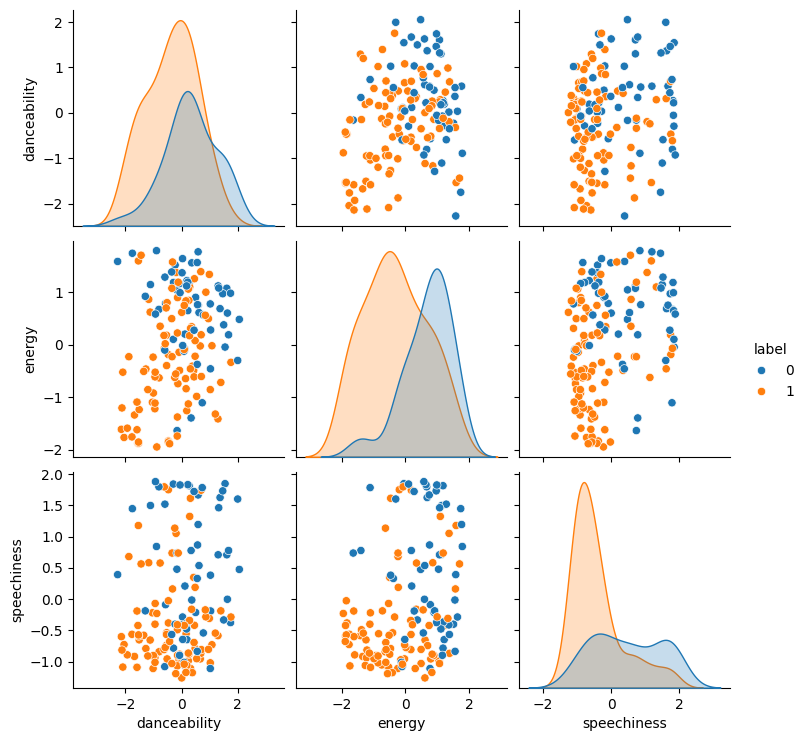

In [132]:
sns.pairplot(data_valuable.head(150),hue='label')

# Aplicación de algoritmos de Machine Learning


Se van a aplicar los siguientes modelos de machine learning en el problema de clasificación:
- Logistic Regression
- KNN
- Decision Trees
- Random Forest
- Suport Vector Machine
- K-means

En cada uno de estos se van a encontrar los mejores hiperparámetros haciendo un grid search, además de obtener las mismas métricas para cada uno.

Se comienza haciendo la separación de los datos en train y test para poder poder usarlos en cada uno de los algoritmos.

In [133]:
from sklearn.model_selection import train_test_split

X = data_valuable[HIGH_LINEAR_CORRELATION_VARIABLES]
y = data_valuable[SALIDA]
y = y.values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)
y_train= y_train.ravel()
print('Los datos de X_train tienen una dimensión de: ', X_train.shape)
print('Los datos de X_test tienen una dimensión de: ', X_test.shape)
print('Los datos de y_train tienen una dimensión de: ', y_train.shape)
print('Los datos de y_test tienen una dimensión de: ', y_test.shape)

Los datos de X_train tienen una dimensión de:  (600, 3)
Los datos de X_test tienen una dimensión de:  (150, 3)
Los datos de y_train tienen una dimensión de:  (600,)
Los datos de y_test tienen una dimensión de:  (150, 1)


Vamos a importar las diferentes librerías que se van a usar en los algoritmos:

In [134]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import accuracy_score

También se van a mostrar la matriz de confusión, la curva ROC y el pairplot de cada modelo, por lo que se va a escribir una función por cada uno.

Creamos una función para mostrar la matriz de confusión de cada modelo:

In [135]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_confusion_matrix(y_test, y_pred):
    cm_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_matrix)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.grid(False)
    disp.plot(ax=ax)

Creamos una función para graficar la curva ROC, y calcular el AUC de cada modelo:

In [136]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def show_curva_roc_results(X_test, y_test, y_pred, clf):
  # Predicciones de las probabilidades de las clases positivas
  y_scores = clf.predict_proba(X_test)[:, 1]
  # Calcula la curva ROC y el AUC
  fpr, tpr, _ = roc_curve(y_test, y_scores)
  roc_auc = auc(fpr, tpr)
  print(f"El valor de AUC para el modelo es: {roc_auc}")
  # Grafica la curva ROC
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2)
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('Tasa de falsos positivos')
  plt.ylabel('Tasa de verdaderos positivos')
  plt.legend(loc="lower right")
  plt.show()
  return roc_auc

Creamos una funcion para graficar los resultados de cada metodo en un pairplot. Vamos a clasificar como correctos a los TP + TN e incorrectos a los FP + FN.

In [137]:
def show_pairplot_results(X_test, y_test, y_pred):
  clasification_results = pd.DataFrame(columns = HIGH_LINEAR_CORRELATION_VARIABLES + ['Resultado'])
  for i, X in X_test.iterrows():
    index = len(clasification_results.index)
    if y_test[index] == y_pred[index]:
        clasification_results.loc[index] = [X['danceability'],X['energy'],X['speechiness'],'Correcto']
    else:
        clasification_results.loc[index] = [X['danceability'],X['energy'],X['speechiness'],'Incorrecto']
  sns.pairplot(clasification_results,hue='Resultado',hue_order=['Correcto','Incorrecto'])

## Logistic Regression

Se comenzará usando el algoritmo de regresión logística. Se va a crear una instancia del clasificador, luego se van a proponer los siguientes hiperparámetros:
- penalty: especifica la norma de penalización, en esta caso la norma l1 y l2 se usaron.
- solver: algorimo a utilizar en el problema de clasificación, liblinear es bueno en datasets pequeños y saga es rápido en datasets grandes.
- max_iter: máximo número de iteraciones para que el solver converja.
- tol: tolerancia como criterio de parada.

Con estos hiperparámetros se va a usar GridSearchCV para encontrar la mejor combinación de parámetros propuestos con un cross-validation de 5. Con el mejor modelo obtenido se va a realizar la predicción y calcular las métricas de precision y F1-scores.

In [138]:
from sklearn.linear_model import LogisticRegression

# Definimos el clasificador
lr = LogisticRegression(random_state=42)

# Hiperparámetros a probar
lr_param_grid = {
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000],
    'tol': [1e-4, 1e-3, 1e-2]
}

# Creamos GridSearchCV para búsqueda exhaustiva de hiperparámetros. Métrica: Precisión.
lr_grid_search = GridSearchCV(estimator=lr, param_grid=lr_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Entrenamos GridSearchCV
lr_grid_search.fit(X_train, y_train)

# Obtenemos el mejor modelo
lr_best_clf = lr_grid_search.best_estimator_

# Predecimos en el conjunto de prueba con el mejor modelo
y_pred_lr = lr_best_clf.predict(X_test)

# Calculo de precision y F1-score
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# Imprimimos resultados
print("Mejores hiperparámetros encontrados:", lr_grid_search.best_params_)
print("Precisión en conjunto de train:", lr_grid_search.best_score_)
print("Precisión en conjunto de prueba:", precision_lr)
print("F1-score en conjunto de prueba:", f1_lr)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros encontrados: {'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.01}
Precisión en conjunto de train: 0.79
Precisión en conjunto de prueba: 0.7942200956937798
F1-score en conjunto de prueba: 0.7937403333493442


El valor de AUC para el modelo es: 0.8597608024691358


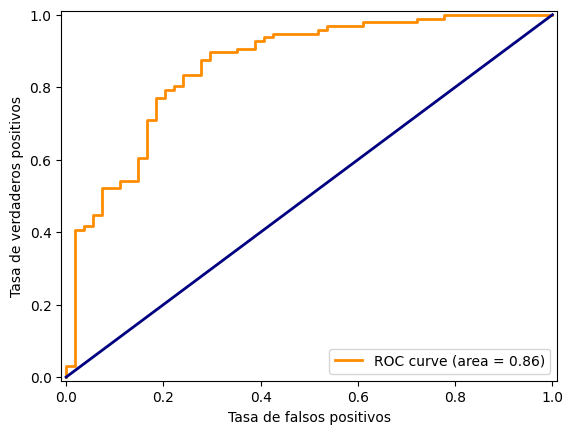

In [139]:
# Curva ROC
auc_lr = show_curva_roc_results(X_test, y_test, y_pred_lr, lr_best_clf)

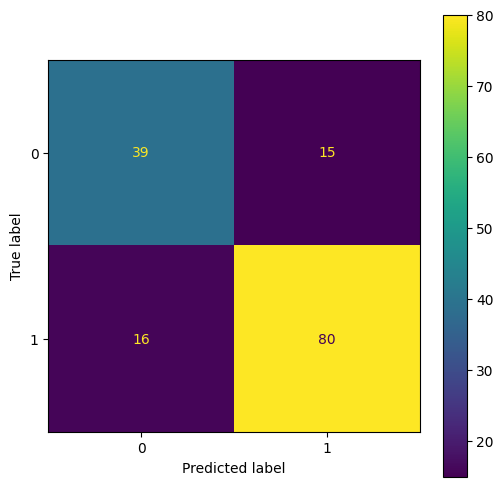

In [140]:
# Matriz de confusión
show_confusion_matrix(y_test, y_pred_lr)

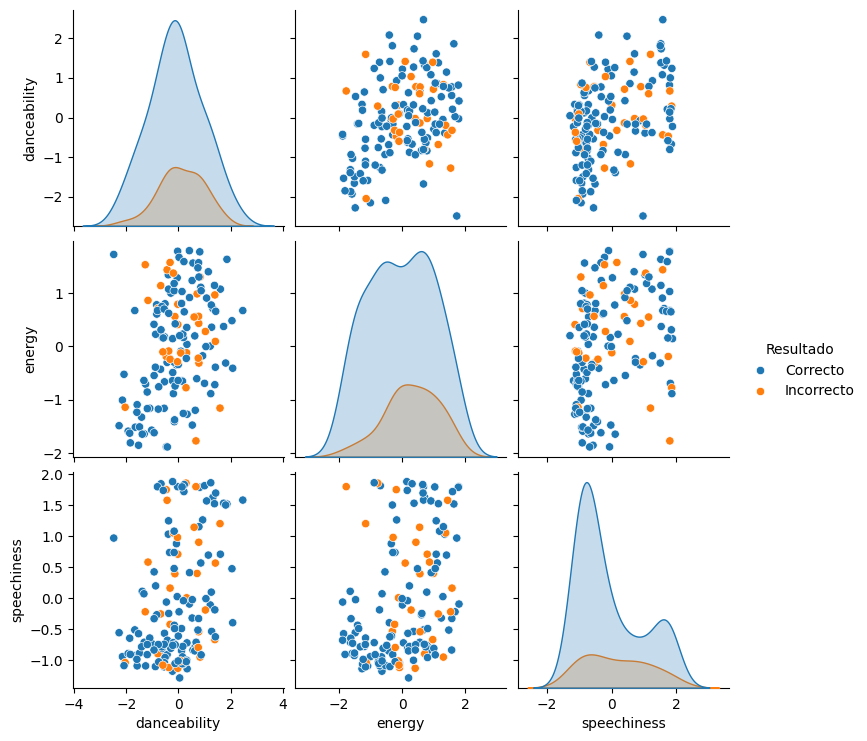

In [141]:
# Pairplot
show_pairplot_results(X_test,y_test,y_pred_lr)

## K-Nearest Neighbors

Ahora se usará el algoritmo de KNN. Se va a crear una instancia del clasificador, luego se van a proponer los siguientes hiperparámetros:
- n_neighbors: representa los vecinos más cercanos para determinar la clase del dato que esto evaluenado, se va a probar con 3, 5, 7 y 9 vecinos más cercanos.
- p: representa la métrica de distancia. Se va a usar 1 que sería la distancia de Manhattan y 2 que sería la distancia Euclidiana.

Con estos hiperparámetros se va a usar GridSearchCV para encontrar la mejor combinación de parámetros propuestos con un cross-validation de 5. Con el mejor modelo obtenido se va a realizar la predicción y calcular las métricas de precision y F1-scores.

In [142]:
from sklearn.neighbors import KNeighborsClassifier

# Definimos el clasificador
knn = KNeighborsClassifier()

# Hiperparámetros a probar
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'p': [1, 2]
}

# Creamos GridSearchCV para búsqueda exhaustiva de hiperparámetros. Métrica: Precisión.
knn_grid_search = GridSearchCV(estimator=knn, param_grid=knn_param_grid, cv=5, scoring='precision', verbose=1, n_jobs=-1)

# Entrenamos GridSearchCV
knn_grid_search.fit(X_train, y_train)

# Obtenemos el mejor modelo
knn_best_clf = knn_grid_search.best_estimator_

# Predecimos en el conjunto de prueba con el mejor modelo
y_pred_knn = knn_best_clf.predict(X_test)

# Calculo de precision y F1-score
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

# Imprimimos resultados
print("Mejores hiperparámetros encontrados:", knn_grid_search.best_params_)
print("Precisión en conjunto de train:", knn_grid_search.best_score_)
print("Precisión en conjunto de prueba:", precision_knn)
print("F1-score en conjunto de prueba:", f1_knn)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejores hiperparámetros encontrados: {'n_neighbors': 3, 'p': 2}
Precisión en conjunto de train: 0.8317001536890561
Precisión en conjunto de prueba: 0.7543732057416268
F1-score en conjunto de prueba: 0.7538191075459916


El valor de AUC para el modelo es: 0.8270640432098766


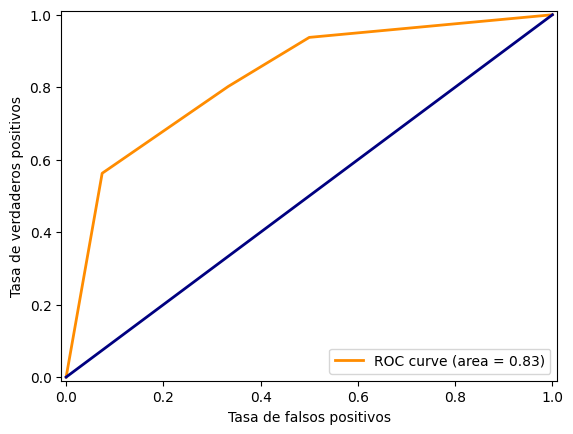

In [143]:
# Curva ROC
auc_knn = show_curva_roc_results(X_test, y_test, y_pred_knn, knn_best_clf)

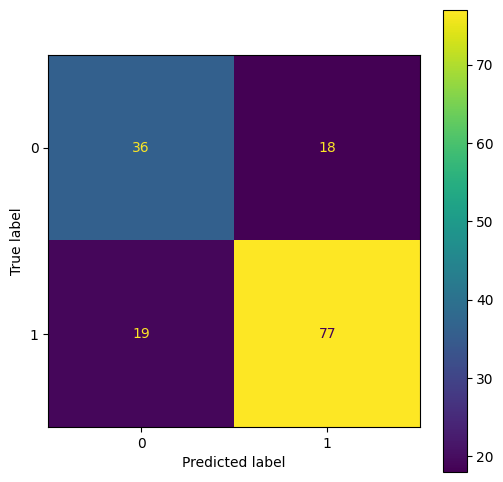

In [144]:
# Matriz de confusión
show_confusion_matrix(y_test, y_pred_knn)

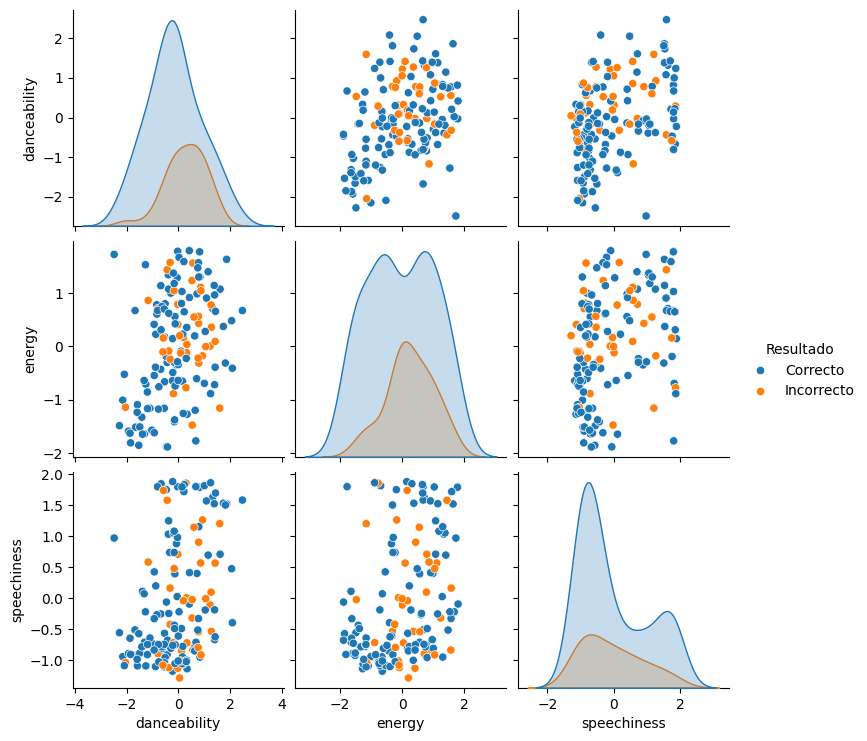

In [145]:
# Pairplot
show_pairplot_results(X_test,y_test,y_pred_knn)

## Decision Trees

Para continuar, seguiremos con un modelo de árbol de decisión. Planteamos los siguientes hiperparámetros entre los cuales elegir:
- criterion: define que criterio se utilizará para medir la calidad de una división en un árbol de decisiones. Los dos criterios más comunes son "gini" y "entropy", que miden la pureza de las divisiones en el árbol.
- max_depth: define la profundidad máxima que puede alcanzar el árbol. Limita la cantidad de niveles de decisiones que puede tener el árbol. Ayuda a controlar el overfitting.
- min_samples_split: es el número mínimo de muestras requeridas para dividir un nodo interno. Controla cuán grande debe ser un nodo antes de dividirse en más nodos. Ayuda a controlar el overfitting.
- min_samples_leaf: es el número mínimo de muestras que deben estar en un nodo hoja. Controla la cantidad mínima de muestras requeridas en un nodo terminal del árbol. Ayuda a controlar el overfitting.

Al igual que en los modelos anteriores, se va a usar GridSearchCV para encontrar la mejor combinación de hiperparámetros propuestos con un cross-validation de 5. Con el mejor modelo obtenido se va a realizar la predicción y calcular las métricas de precision y F1-scores.

In [146]:
from sklearn.tree import DecisionTreeClassifier

# Definimos el clasificador
dt = DecisionTreeClassifier(random_state=42)

# Definimos la grilla de hiperparámetros a explorar
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 4, 8, 16, 32],
    'min_samples_leaf': [1, 2, 4, 8]
}

# Creamos GridSearchCV para búsqueda exhaustiva de hiperparámetros. Métrica: Precisión.
dt_grid_search = GridSearchCV(estimator=dt, param_grid=dt_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Entrenamos GridSearchCV
dt_grid_search.fit(X_train, y_train)

# Obtenemos el mejor modelo
dt_best_clf = dt_grid_search.best_estimator_

# Predecimos en el conjunto de prueba con el mejor modelo
y_pred_dt = dt_best_clf.predict(X_test)

# Calculamos precision y F1-score
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

# Imprimimos resultados
print("Mejores hiperparámetros encontrados:", dt_grid_search.best_params_)
print("Precisión en conjunto de train:", dt_grid_search.best_score_)
print("Precisión en conjunto de prueba:", precision_dt)
print("F1-score en conjunto de prueba:", f1_dt)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Mejores hiperparámetros encontrados: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 2}
Precisión en conjunto de train: 0.78
Precisión en conjunto de prueba: 0.8079913916786227
F1-score en conjunto de prueba: 0.7905175907165223


El valor de AUC para el modelo es: 0.8588927469135802


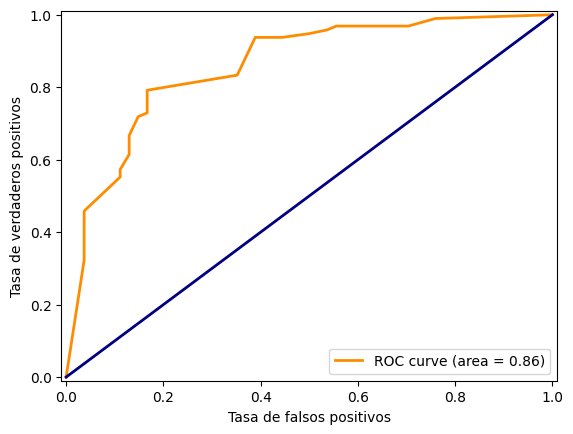

In [147]:
# Curva ROC
auc_dt = show_curva_roc_results(X_test, y_test, y_pred_dt, dt_best_clf)

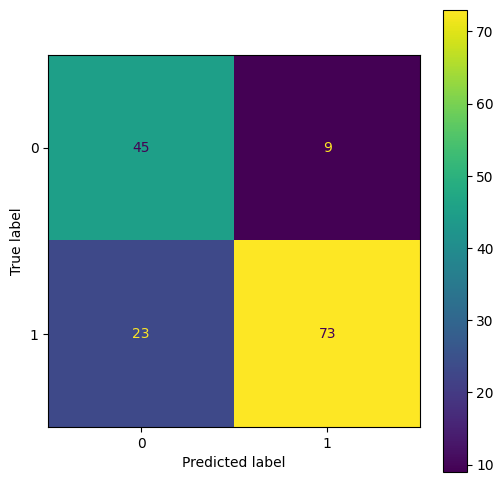

In [148]:
# Matriz de confusión
show_confusion_matrix(y_test, y_pred_dt)

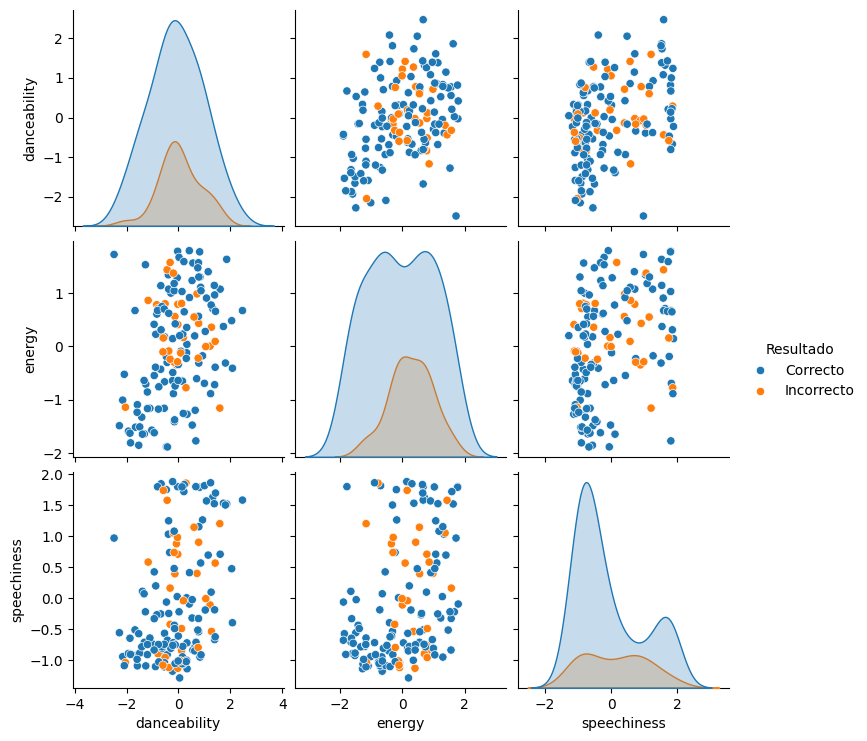

In [149]:
# Pairplot
show_pairplot_results(X_test,y_test,y_pred_dt)

## Random Forest

Continuando con el metodo de Random Forest. Se va a crear una instancia del clasificador, luego se van a proponer los siguientes hiperparámetros:
- criterion: la función que mide la calidad de la separación.
- n_estimators: la cantidad de arboles en el bosque (en general números muy grandes hacen que el método tarde mucho entrenar)
- max_depth: máxima profundidad del árbol. "None" significa no hay máximo.
- max_features: la cantidad de parametros a considerar cuando decidiendo la mejor separacion. "None" simboliza usar todos.
- cpp_alpha: penalización por complejidad del árbol. Importante para evitar el overfitting.

Con estos hiperparámetros se va a usar GridSearchCV para encontrar la mejor combinación de parámetros propuestos con un cross-validation de 5. Con el mejor modelo obtenido se va a realizar la predicción y calcular las métricas de precision y F1-scores.

In [150]:
from sklearn.ensemble import RandomForestClassifier

# Definimos el clasificador
rf = RandomForestClassifier(random_state=42)

# Definimos la grilla de hiperparámetros a explorar
rf_param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', None],
    'ccp_alpha': [0.01 , 0.1]
}
# Creamos GridSearchCV para búsqueda exhaustiva de hiperparámetros. Métrica: Precisión.
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Entrenamos GridSearchCV
rf_grid_search.fit(X_train, y_train)

# Obtenemos el mejor modelo
rf_best_clf = rf_grid_search.best_estimator_

# Predecimos en el conjunto de prueba con el mejor modelo
y_pred_rf = rf_best_clf.predict(X_test)

# Calculamos precision y F1-score
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

# Imprimimos resultados
print("Mejores hiperparámetros encontrados:", rf_grid_search.best_params_)
print("Precisión en conjunto de train:", rf_grid_search.best_score_)
print("Precisión en conjunto de prueba:", precision_rf)
print("F1-score en conjunto de prueba:", f1_rf)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores hiperparámetros encontrados: {'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}
Precisión en conjunto de train: 0.8116666666666668
Precisión en conjunto de prueba: 0.8340669856459331
F1-score en conjunto de prueba: 0.833661559152697


El valor de AUC para el modelo es: 0.8683449074074073


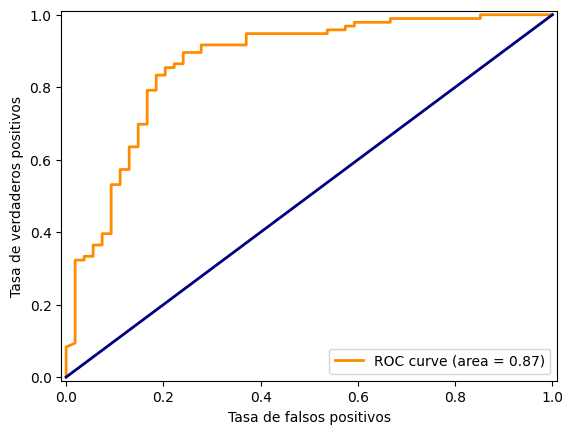

In [151]:
# Curva ROC
auc_rf = show_curva_roc_results(X_test, y_test, y_pred_rf, rf_best_clf)

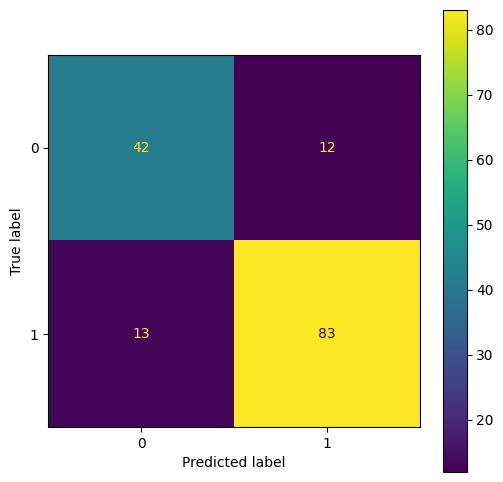

In [152]:
# Matriz de confusión
show_confusion_matrix(y_test, y_pred_rf)

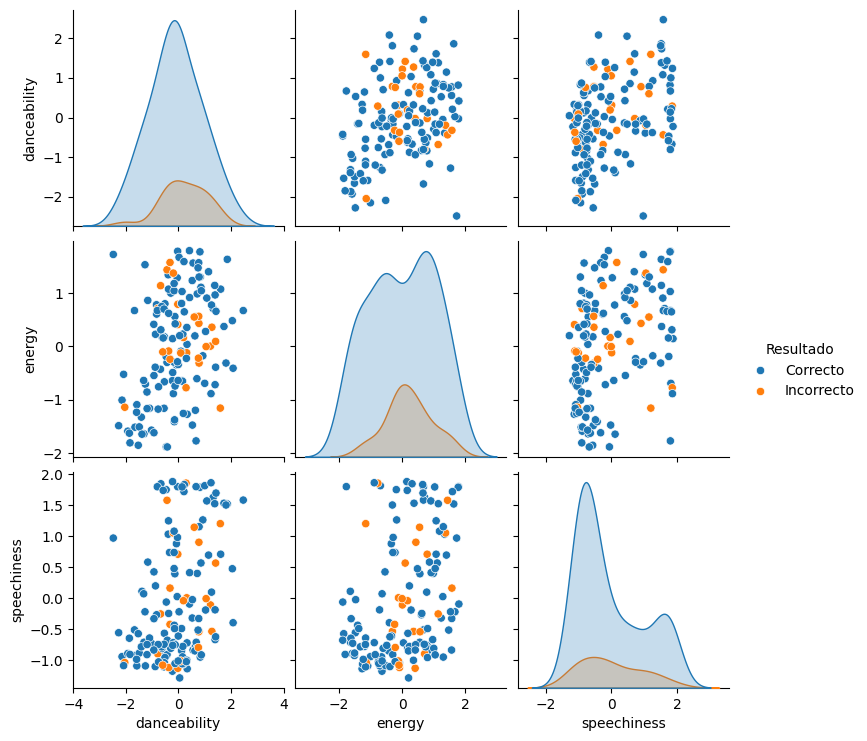

In [153]:
# Pairplot
show_pairplot_results(X_test,y_test,y_pred_rf)

## Support Vector Machine

Continuando con el metodo de Suppor vector machine. Se va a crear una instancia del clasificador, luego se van a proponer los siguientes hiperparámetros:
- kernel: el tipo de kernel utilizado. Lineal, polinómico, basado en funciones radiales (rbf) o sigmoideo.
- C: parametro de regularización. Se utiliza la penalización l2 al cuadrado.
- decision_function_shape: si la decisión es ovo: uno contra uno o ovr: uno contra el resto.

Con estos hiperparámetros se va a usar GridSearchCV para encontrar la mejor combinación de parámetros propuestos con un cross-validation de 5. Con el mejor modelo obtenido se va a realizar la predicción y calcular las métricas de precision y F1-scores.

In [154]:
from sklearn import svm

# Definimos el clasificador
svm = svm.SVC(random_state=42,probability = True)

# Definimos la grilla de hiperparámetros a explorar
svm_param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': np.linspace(0.1 ,0.9 ,10),
    'decision_function_shape':['ovr','ovo'],
}
# Creamos GridSearchCV para búsqueda exhaustiva de hiperparámetros. Métrica: Precisión.
svm_grid_search = GridSearchCV(estimator=svm, param_grid=svm_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Entrenamos GridSearchCV
svm_grid_search.fit(X_train, y_train)

# Obtenemos el mejor modelo
svm_best_clf = svm_grid_search.best_estimator_

# Predecimos en el conjunto de prueba con el mejor modelo
y_pred_svm = svm_best_clf.predict(X_test)

# Calculamos precision y F1-score
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

# Imprimimos resultados
print("Mejores hiperparámetros encontrados:", svm_grid_search.best_params_)
print("Precisión en conjunto de train:", svm_grid_search.best_score_)
print("Precisión en conjunto de prueba:", precision_svm)
print("F1-score en conjunto de prueba:", f1_svm)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Mejores hiperparámetros encontrados: {'C': 0.8111111111111111, 'decision_function_shape': 'ovr', 'kernel': 'rbf'}
Precisión en conjunto de train: 0.8033333333333333
Precisión en conjunto de prueba: 0.84
F1-score en conjunto de prueba: 0.84


El valor de AUC para el modelo es: 0.8379629629629629


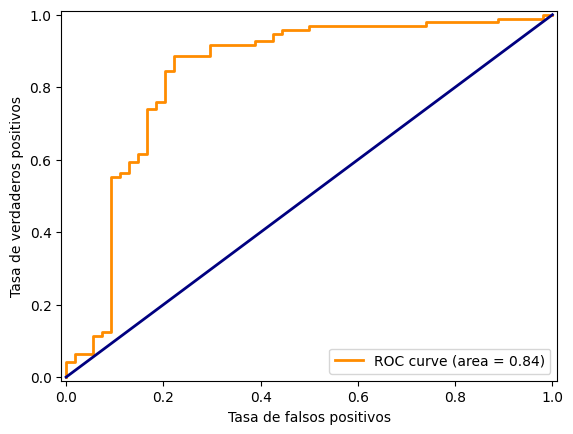

In [155]:
# Curva ROC
auc_svm = show_curva_roc_results(X_test, y_test, y_pred_svm, svm_best_clf)

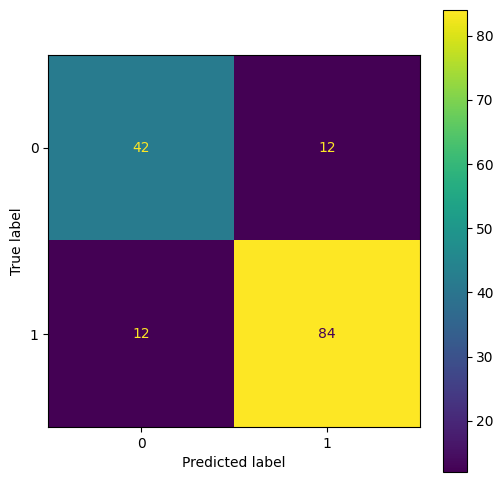

In [156]:
# Matriz de confusión
show_confusion_matrix(y_test, y_pred_svm)

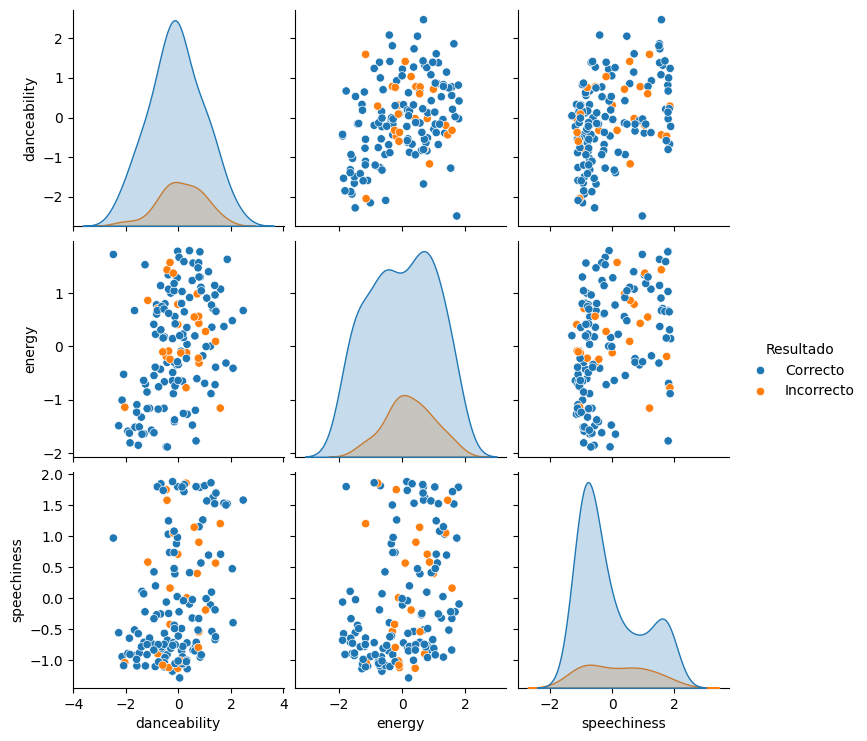

In [157]:
# Pairplot
show_pairplot_results(X_test,y_test,y_pred_svm)

## K-means

In [158]:
from sklearn.cluster import KMeans

# Entrenamos en primer lugar, el modelo con sus hiperparámetros por defecto (inicialización k-means++):
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
kmeans.fit(X_train)

clusters_train = kmeans.predict(X_train)
clusters_test = kmeans.predict(X_test)

precision_train = precision_score(y_train, clusters_train, average='weighted')
f1_train = f1_score(y_train, clusters_train, average='weighted')

precision_test = precision_score(y_test, clusters_test, average='weighted')
f1_test = f1_score(y_test, clusters_test, average='weighted')

print("Precisión en train:", precision_train)
print("F1-score en train:", f1_train)
print("Precisión en test:", precision_test)
print("F1-score en test:", f1_test)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Precisión en train: 0.8170209330704966
F1-score en train: 0.7795114570904914
Precisión en test: 0.7775075771082189
F1-score en test: 0.7318968078879834


A continuación, vamos a entrenar modelos con variantes en sus hiperparámetros, y comparar resultados:

In [159]:
# Entrenamos el modelo con su inicialización random:
kmeans = KMeans(n_clusters=2, init='random', random_state=42)
kmeans.fit(X_train)

clusters_train = kmeans.predict(X_train)
clusters_test = kmeans.predict(X_test)

precision_train = precision_score(y_train, clusters_train, average='weighted')
f1_train = f1_score(y_train, clusters_train, average='weighted')

precision_test = precision_score(y_test, clusters_test, average='weighted')
f1_test = f1_score(y_test, clusters_test, average='weighted')

print("Precisión en train:", precision_train)
print("F1-score en train:", f1_train)
print("Precisión en test:", precision_test)
print("F1-score en test:", f1_test)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Precisión en train: 0.8170209330704966
F1-score en train: 0.7795114570904914
Precisión en test: 0.7775075771082189
F1-score en test: 0.7318968078879834


In [160]:
from sklearn.cluster import MiniBatchKMeans

# Probamos mini-batch con un tamaño de 100 muestras:
batch_size = 100
kmeans_minibatch = MiniBatchKMeans(n_clusters=2, batch_size=batch_size, random_state=42)

kmeans_minibatch.fit(X_train)
test_clusters = kmeans_minibatch.predict(X_test)

precision = precision_score(y_test, test_clusters, average='weighted')
f1 = f1_score(y_test, test_clusters, average='weighted')

print("Precisión:", precision)
print("F1-score:", f1)

Precisión: 0.2769570823356051
F1-score: 0.24169970157231305


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [161]:
# Probamos mini-batch con un tamaño de 200 muestras:
batch_size = 200
kmeans_minibatch = MiniBatchKMeans(n_clusters=2, batch_size=batch_size, random_state=42)

kmeans_minibatch.fit(X_train)
test_clusters = kmeans_minibatch.predict(X_test)

precision_kmeans = precision_score(y_test, test_clusters, average='weighted')
f1_kmeans = f1_score(y_test, test_clusters, average='weighted')

print("Precisión:", precision_kmeans)
print("F1-score:", f1_kmeans)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Precisión: 0.7839613526570048
F1-score: 0.7316363636363636


Para cerrar, mostramos un cuadro comparativo con los resultados de los modelos probados:

| Modelo          | Inicialización                       | Tamaño de batch | Precisión | F1-Score |
| :---------------- | :---------------------:    | ----------------: |----------------: | :---------------- |
| K-means      |  K-means++   | 600 | 0,7775  | 0,7319|
| K-means      |  Random   | 600 | 0,7775 | 0,7319|
| K-means          |  K-means++   | 200 | 0,7840 | 0,7316|
| K-means            |  K-means++   | 100 | 0,2770 | 0,2417|

En base a estas métricas, nos quedamos con la tercer variante de este modelo con un tamaño de minibatch de 200.
A continuación, se muestra la matriz de confusión del modelo. Cabe aclarar que en el caso de K-means, no se muestra la curva ROC debido a que no se trata de un modelo de clasificación binaria, sino de un algoritmo de clustering no supervisado.

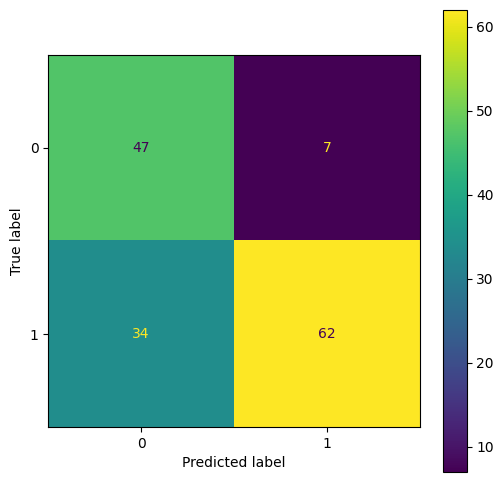

In [162]:
# Predicciones en el conjunto de prueba
y_pred_means = kmeans_minibatch.predict(X_test)

# Matriz de confusión
show_confusion_matrix(y_test, y_pred_means)

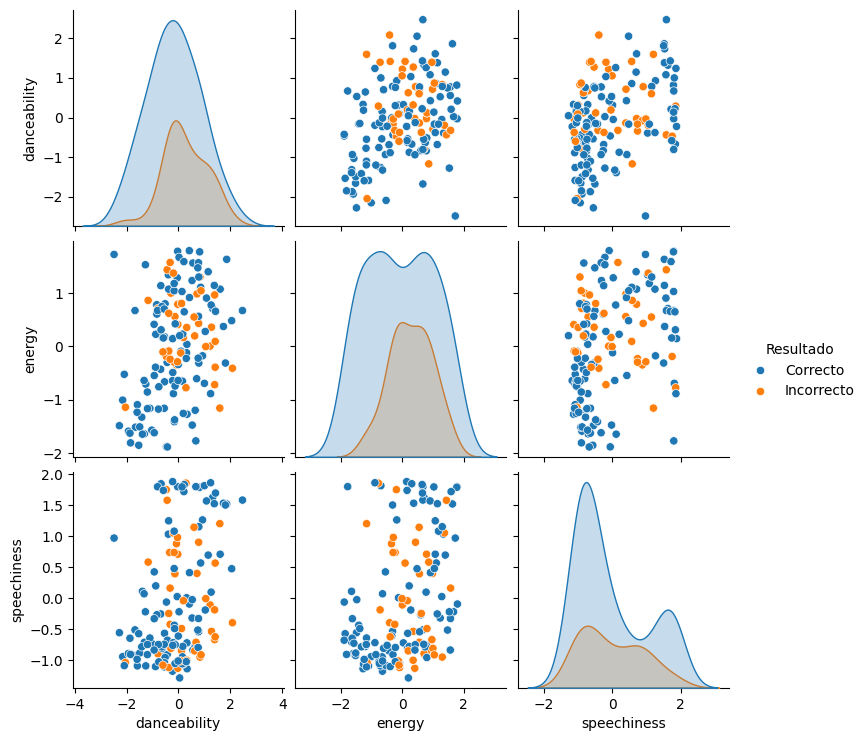

In [163]:
show_pairplot_results(X_test,y_test,y_pred_means)

## Comparación de algoritmos y selección del mejor para este problema

A continuación, se va a mostrar una tabla comparativa de los resultado de los algoritmos empleados.

In [164]:
from tabulate import tabulate
resultados = {
    "Algorithm": ["Logistic Regression", "KNN", "Decision Tree", "Random Forest", "Support Vector Machine", "K-means"],
    "Precision": [precision_lr, precision_knn, precision_dt, precision_rf, precision_svm, precision_kmeans],
    "F1-score": [f1_lr, f1_knn, f1_dt, f1_rf, f1_svm, f1_kmeans],
    "AUC": [auc_lr, auc_knn, auc_dt, auc_rf, auc_svm, None]
}
encabezados = ["Algorithm", "Precision (test)", "F1-score (test)", "AUC"]
print(tabulate(resultados, headers=encabezados, floatfmt=".5f"))

Algorithm                 Precision (test)    F1-score (test)      AUC
----------------------  ------------------  -----------------  -------
Logistic Regression                0.79422            0.79374  0.85976
KNN                                0.75437            0.75382  0.82706
Decision Tree                      0.80799            0.79052  0.85889
Random Forest                      0.83407            0.83366  0.86834
Support Vector Machine             0.84000            0.84000  0.83796
K-means                            0.78396            0.73164


En la tabla comparativa se observa que el algortimo que tuve el mejor resultado en precision fue SVM, al igual que obtuvo el mejor resultado con el F1-score. En cuanto al valor de AUC (área bajo la curva), el modelo que tuvo mejor resultado fue Random Forest.

Como conclusión de este análisis, podemos afirmar que los mejores algoritmos para este problema de clasificación fueron Random Forest y Support Vector Machine.

# Conclusión

Se pudo aplicar los conocimientos adquiridos en el cursado para un problema de clasificación. Se pudo evaluar la performance de seis algoritmos de clasificación para compararlos y obtener entre ellos el que mejor se ajustó al problema. Además, para cada uno de ellos se consideraron múltiples variantes que podrían tener importancia para el problema.

Se podría seguir trabajando con este dataset a futuro para aplicar técnicas de deep learning. Aplicando una red feed-forward con una sola salida para la clasificación binaria.